In [3]:
import kumoai.experimental.rfm as rfm, os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
home_api_key_file = Path.home() / "kumoai_key.txt"
with open(home_api_key_file, "r") as file:
    api_key = file.read().strip()
os.environ["KUMO_API_KEY"] = api_key

rfm.init()

[2025-08-18 01:00:44 - kumoai:196 - INFO] Successfully initialized the Kumo SDK against deployment https://kumorfm.ai/api, with log level INFO.


## Exercise

Create a synthetic dataset with the purpose of testing how KumoRFM deals with temporal dependency that is not in the transactional history, but instead is in a user type variable that can change over time.
Essentially, there are users of 2 types (premium/free), and premium users can do actions that free users cannot.
The exercise is about testing if KumoRFM detects this dependency and considers it for predictions.

### Dataset description
- Create a synthetic dataset representing users of 2 types (tier free or tier premium), uploading files of different sizes, and with their user tiers changing over time.
- While on Premium tier, users can upload any size. 
- While on free tier, users can upload files below 10GB. 
- For simplicity, there are only 2 sizes: 5GB and 50GB.
- Users can change their tier no earlier than 24 hours after the last change. 
- There are 50 users, covering 5 cohorts:
    - Always premium (unknown start) → a single interval that spans the whole window.
    - Always free → a single interval that spans the whole window.
    - Premium → Free once (≥24h after start).
    - Free → Premium once (≥24h).
    - Free → Premium → Free (each change ≥24h apart; all within window).
- The history of transactions last 10 days from March 1st to March 11th, 2025.
- The prediction tasks will be done for different users, predicting their likelihood that they will upload a 50GB file in the next hour.
- Expectations: 
    - For users that just became free tier this should be 0.
    - For users that just became Premium it should >> 0.

### Tables

- users (50 users). This set is just random ids and names.
    - user_id (PK)
    - name

- items (80 different items: 45 of 5 GB, 35 of 50 GB). Basically random ids.
    - item_id (PK)
    - size_gb in {5, 50}

- tiers. See creation process below.
    - tier_status_id (PK)
    - user_id (FK -> users.user_id)
    - from_datetime
    - until_datetime
    - status in {'free', 'premium'}


- uploads. See creation process below.
    - upload_id (PK)
    - user_id (FK -> users.user_id)
    - item_id (FK -> items.item_id)
    - datetime


### Creation process (not efficient, prioritize simplicity/clarity)

- tiers:
    - User ids from 1 to 10: always premium: 1 row in tiers.
        - from_date = START, until_date = END, status = 'premium'
    - User ids from 11 to 20: always free: 1 row in tiers.
        - from_date = START, until_date = END: status = 'free'    
    - User ids from 21 to 30: premium to free: 2 rows in tiers.
        - Take a random date X in (START, END)
        - from_date = START, until_date = X: status = 'premium'
        - from_date = X, until_date = END: status = 'free'
    - user ids from 31 to 40: free to premium: 2 rows in tiers.
        - Take a random date X in (START, END)
        - from_date = START, until_date = X: status = 'free'
        - from_date = X, until_date = END: status = 'premium'
    - user ids from 41 to 50: free to premium to free: 3 rows in tiers.
        - Take random dates X1 < X2 in (START, END)
        - from_date = START, until_date = X1: status = 'free'
        - from_date = X1, until_date = X2: status = 'premium'
        - from_date = X2, until_date = END: status = 'free'

- uploads:
    - for each tier_status_id, create the uploads in the corresponding interval.
    - Given a tier_status_id, get the details: user_id, from_date, until_date, status.
    - If status = 'free':
        - compute the number of hours delta_h from from_date to until_date.
        - take a sample of r = ceil(delta_h/10) times in (from_date, until_date).
        - use those as datetime.
        - generate the corresponding number of rows for uploads.
        - keep track of the last generated upload_id.
        - the user_id is the current one.
        - items_id's should be taken at random from those with 5GB.
    - if status = 'premium':
        - Do the same as for free users (5GB files).
        - Then repeat but for 50GB files.


In [5]:
import csv
import math
import random
from datetime import datetime, timedelta, timezone

# ----------------------------
# Config
# ----------------------------
SEED = 42
random.seed(SEED)

START = datetime(2025, 3, 1, 0, 0, 0, tzinfo=timezone.utc)
END   = datetime(2025, 3, 11, 0, 0, 0, tzinfo=timezone.utc)  # half-open [START, END)

USERS_CSV   = "users.csv"
ITEMS_CSV   = "items.csv"
TIERS_CSV   = "tiers.csv"
UPLOADS_CSV = "uploads.csv"

N_USERS = 50
N_ITEMS_5GB = 45
N_ITEMS_50GB = 35

# ----------------------------
# Helpers
# ----------------------------
def rand_dt(a, b):
    total_sec = int((b - a).total_seconds())
    if total_sec <= 1:
        return a + timedelta(seconds=1)
    off = random.randint(1, total_sec - 1)
    return a + timedelta(seconds=off)

def sample_times(n, a, b):
    return [rand_dt(a, b) for _ in range(n)]

def hours_between(a, b):
    return (b - a).total_seconds() / 3600.0

# ----------------------------
# 1) users
# ----------------------------
users = []
for uid in range(1, N_USERS + 1):
    users.append([uid, f"User {uid:03d}"])

# ----------------------------
# 2) items
# ----------------------------
items = []
for iid in range(1, N_ITEMS_5GB + 1):
    items.append([iid, 5])
for iid in range(N_ITEMS_5GB + 1, N_ITEMS_5GB + N_ITEMS_50GB + 1):
    items.append([iid, 50])

item_ids_5 = [row[0] for row in items if row[1] == 5]
item_ids_50 = [row[0] for row in items if row[1] == 50]

# ----------------------------
# 3) tiers
# ----------------------------
tiers = []
tier_status_id = 1

def add_interval(uid, a, b, status):
    global tier_status_id
    tiers.append([tier_status_id, uid, a, b, status])
    tier_status_id += 1

# always premium
for uid in range(1, 11):
    add_interval(uid, START, END, "premium")

# always free
for uid in range(11, 21):
    add_interval(uid, START, END, "free")

# premium -> free
for uid in range(21, 31):
    lo = START + timedelta(hours=24)
    hi = END - timedelta(hours=24)
    x = lo + timedelta(seconds=random.randint(0, int((hi - lo).total_seconds())))
    add_interval(uid, START, x, "premium")
    add_interval(uid, x, END, "free")

# free -> premium
for uid in range(31, 41):
    lo = START + timedelta(hours=24)
    hi = END - timedelta(hours=24)
    x = lo + timedelta(seconds=random.randint(0, int((hi - lo).total_seconds())))
    add_interval(uid, START, x, "free")
    add_interval(uid, x, END, "premium")

# free -> premium -> free
for uid in range(41, 51):
    lo1 = START + timedelta(hours=24)
    hi1 = END - timedelta(hours=48)
    x1 = lo1 + timedelta(seconds=random.randint(0, int((hi1 - lo1).total_seconds())))

    lo2 = x1 + timedelta(hours=24)
    hi2 = END - timedelta(seconds=1)
    if lo2 >= hi2:
        hi2 = x1 + timedelta(hours=48)
    x2 = lo2 + timedelta(seconds=random.randint(0, int((hi2 - lo2).total_seconds())))

    add_interval(uid, START, x1, "free")
    add_interval(uid, x1, x2, "premium")
    add_interval(uid, x2, END, "free")

# ----------------------------
# 4) uploads
# ----------------------------
uploads = []
upload_id = 1

for row in tiers:
    uid = row[1]
    a = row[2]
    b = row[3]
    status = row[4]

    delta_h = hours_between(a, b)
    if delta_h <= 0:
        continue

    if status == "free":
        r = math.ceil(delta_h / 10.0)
        times = sample_times(r, a, b)
        for t in times:
            uploads.append([upload_id, uid, random.choice(item_ids_5), t])
            upload_id += 1

    if status == "premium":
        r5 = math.ceil(delta_h / 10.0)
        times5 = sample_times(r5, a, b)
        for t in times5:
            uploads.append([upload_id, uid, random.choice(item_ids_5), t])
            upload_id += 1

        r50 = math.ceil(delta_h / 10.0)
        times50 = sample_times(r50, a, b)
        for t in times50:
            uploads.append([upload_id, uid, random.choice(item_ids_50), t])
            upload_id += 1

# ----------------------------
# Write CSVs
# ----------------------------
with open(USERS_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["user_id", "name"])
    w.writerows(users)

with open(ITEMS_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["item_id", "size_gb"])
    w.writerows(items)

with open(TIERS_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["tier_status_id", "user_id", "from_datetime", "until_datetime", "status"])
    for tr in tiers:
        w.writerow([
            tr[0],
            tr[1],
            tr[2].strftime("%Y-%m-%dT%H:%M:%SZ"),
            tr[3].strftime("%Y-%m-%dT%H:%M:%SZ"),
            tr[4]
        ])

with open(UPLOADS_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["upload_id", "user_id", "item_id", "datetime"])
    for up in uploads:
        w.writerow([
            up[0],
            up[1],
            up[2],
            up[3].strftime("%Y-%m-%dT%H:%M:%SZ")
        ])

print("Done. Wrote:", USERS_CSV, ITEMS_CSV, TIERS_CSV, UPLOADS_CSV)


Done. Wrote: users.csv items.csv tiers.csv uploads.csv


In [6]:
users_df = pd.read_csv(USERS_CSV)
tiers_df = pd.read_csv(TIERS_CSV)
items_df = pd.read_csv(ITEMS_CSV)
uploads_df = pd.read_csv(UPLOADS_CSV)

In [7]:
uploads_df = uploads_df.merge(items_df)

In [8]:
display(users_df.head(3))
display(tiers_df.head(3))
display(items_df.head(3))
display(uploads_df.head(3))


,user_id,name
0,1,User 001
1,2,User 002
2,3,User 003


,tier_status_id,user_id,from_datetime,until_datetime,status
0,1,1,2025-03-01T00:00:00Z,2025-03-11T00:00:00Z,premium
1,2,2,2025-03-01T00:00:00Z,2025-03-11T00:00:00Z,premium
2,3,3,2025-03-01T00:00:00Z,2025-03-11T00:00:00Z,premium


,item_id,size_gb
0,1,5
1,2,5
2,3,5


,upload_id,user_id,item_id,datetime,size_gb
0,1,1,15,2025-03-02T04:10:15Z,5
1,2,1,19,2025-03-05T08:33:38Z,5
2,3,1,6,2025-03-05T04:11:04Z,5


In [9]:
print(users_df.shape[0], users_df['user_id'].nunique())
print(tiers_df.shape[0], tiers_df['tier_status_id'].nunique())
print(items_df.shape[0], items_df['item_id'].nunique())
print(uploads_df.shape[0], uploads_df['upload_id'].nunique())


50 50
90 90
80 80
1788 1788


In [10]:
def plot_user_uploads(tiers_df, uploads_df, items_df, user_id, title=None):
    # Ensure datetime dtype
    tiers = tiers_df.loc[tiers_df.user_id == user_id].copy()
    tiers["from_datetime"] = pd.to_datetime(tiers["from_datetime"])
    tiers["until_datetime"] = pd.to_datetime(tiers["until_datetime"])

    uploads = uploads_df.loc[uploads_df.user_id == user_id].copy()
    uploads["datetime"] = pd.to_datetime(uploads["datetime"])

    
    # Set x-limits from tier coverage (fallback to upload range if needed)
    if not tiers.empty:
        xmin = tiers["from_datetime"].min()
        xmax = tiers["until_datetime"].max()
    else:
        xmin = uploads["datetime"].min()
        xmax = uploads["datetime"].max()

    # Plot
    fig, ax = plt.subplots(figsize=(10, 3.5))

    # Background: tier intervals
    # (label only once to keep legend clean)
    added_free = False
    added_premium = False
    for _, r in tiers.sort_values("from_datetime").iterrows():
        color = "green" if r["status"] == "free" else "blue"
        label = None
        if r["status"] == "free" and not added_free:
            label = "free"
            added_free = True
        if r["status"] == "premium" and not added_premium:
            label = "premium"
            added_premium = True
        ax.axvspan(r["from_datetime"], r["until_datetime"], color=color, alpha=0.15, label=label)

    # Upload points at y = 5 or 50
    if not uploads.empty:
        ax.scatter(uploads["datetime"], uploads["size_gb"], s=25, zorder=3)

    # Axes, labels, ticks
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(0, 55)
    ax.set_yticks([5, 50])
    ax.set_xlabel("time")
    ax.set_ylabel("GB")

    if title is None:
        title = f"User {user_id} uploads"
    ax.set_title(title)

    # Legend (only if any tier intervals exist)
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(loc="upper left")

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


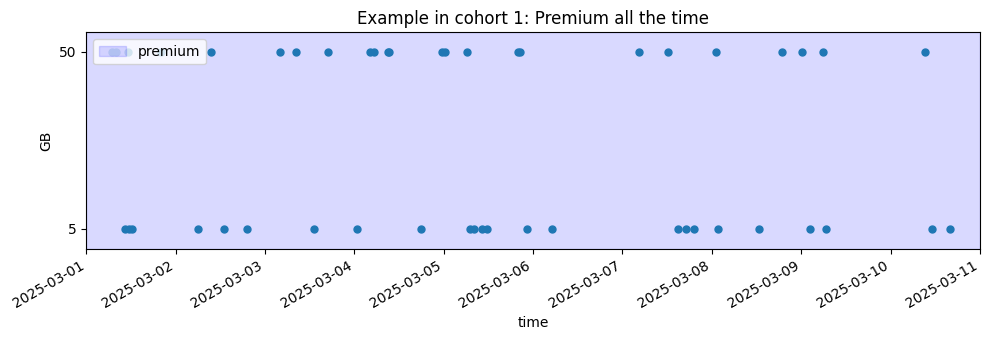

In [11]:
plot_user_uploads(tiers_df, uploads_df, items_df, 5, "Example in cohort 1: Premium all the time")

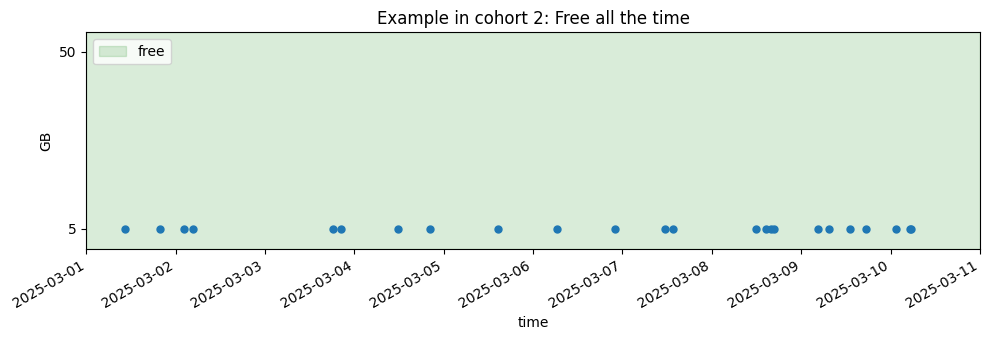

In [12]:
plot_user_uploads(tiers_df, uploads_df, items_df, 15, "Example in cohort 2: Free all the time")

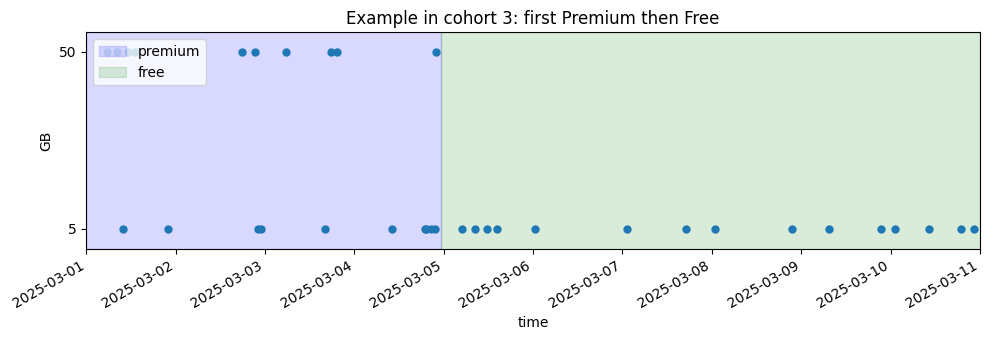

In [13]:
plot_user_uploads(tiers_df, uploads_df, items_df, 25, "Example in cohort 3: first Premium then Free")

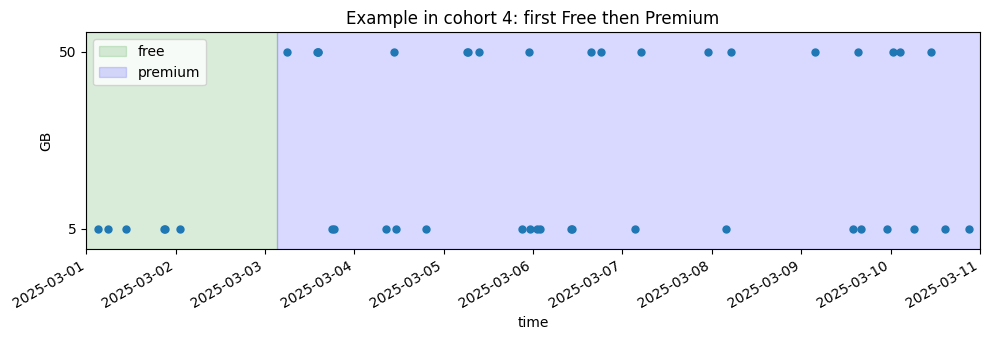

In [14]:
plot_user_uploads(tiers_df, uploads_df, items_df, 35, "Example in cohort 4: first Free then Premium")

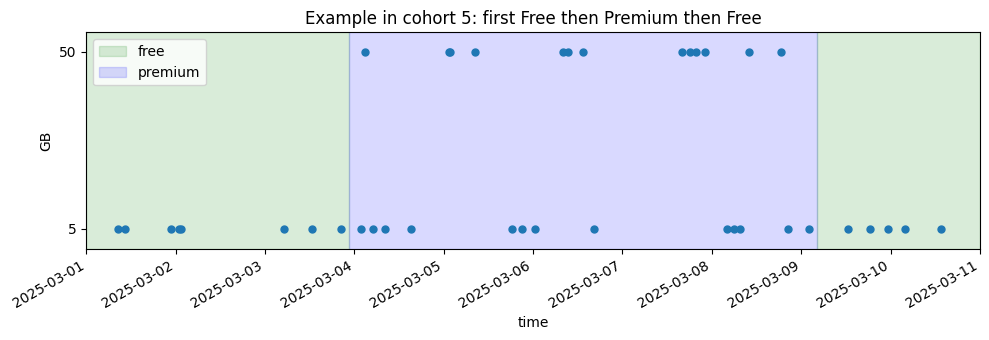

In [15]:
plot_user_uploads(tiers_df, uploads_df, items_df, 45, "Example in cohort 5: first Free then Premium then Free")

In [16]:
display(users_df.head(3))
display(tiers_df.head(3))
display(items_df.head(3))
display(uploads_df.head(3))

,user_id,name
0,1,User 001
1,2,User 002
2,3,User 003


,tier_status_id,user_id,from_datetime,until_datetime,status
0,1,1,2025-03-01T00:00:00Z,2025-03-11T00:00:00Z,premium
1,2,2,2025-03-01T00:00:00Z,2025-03-11T00:00:00Z,premium
2,3,3,2025-03-01T00:00:00Z,2025-03-11T00:00:00Z,premium


,item_id,size_gb
0,1,5
1,2,5
2,3,5


,upload_id,user_id,item_id,datetime,size_gb
0,1,1,15,2025-03-02T04:10:15Z,5
1,2,1,19,2025-03-05T08:33:38Z,5
2,3,1,6,2025-03-05T04:11:04Z,5


In [17]:
#items_df.loc[items_df.size_gb == 5].item_id.max()

In [18]:
users = rfm.LocalTable(users_df, name="users").infer_metadata()
tiers = rfm.LocalTable(tiers_df, name="tiers").infer_metadata()
items = rfm.LocalTable(items_df, name="items").infer_metadata()
uploads = rfm.LocalTable(uploads_df, name="uploads").infer_metadata()


Detected primary key 'user_id' in table 'users'
Detected time column 'from_datetime' in table 'tiers'
Detected primary key 'item_id' in table 'items'
Detected primary key 'upload_id' and time column 'datetime' in table 'uploads'


In [19]:
users.print_metadata()

### 🏷️ Metadata of Table `users` (50 rows)

name,dtype,stype,is_primary_key,is_time_column
user_id,int,ID,True,False
name,string,text,False,False


In [20]:
tiers.primary_key = "tier_status_id"
tiers.print_metadata()

### 🏷️ Metadata of Table `tiers` (90 rows)

name,dtype,stype,is_primary_key,is_time_column
tier_status_id,int,ID,True,False
user_id,int,ID,False,False
from_datetime,string,timestamp,False,True
until_datetime,string,timestamp,False,False
status,string,categorical,False,False


In [21]:
items['size_gb'].stype = "numerical"
items.print_metadata()

### 🏷️ Metadata of Table `items` (80 rows)

name,dtype,stype,is_primary_key,is_time_column
item_id,int,ID,True,False
size_gb,int,numerical,False,False


In [22]:
uploads['size_gb'].stype = "numerical"
uploads.print_metadata()

### 🏷️ Metadata of Table `uploads` (1,788 rows)

name,dtype,stype,is_primary_key,is_time_column
upload_id,int,ID,True,False
user_id,int,ID,False,False
item_id,int,ID,False,False
datetime,string,timestamp,False,True
size_gb,int,numerical,False,False


In [23]:
graph = rfm.LocalGraph(tables=[users, tiers, items, uploads])

In [24]:
graph.link(src_table="tiers", fkey="user_id", dst_table="users");
graph.link(src_table="uploads", fkey="item_id", dst_table="items");
graph.link(src_table="uploads", fkey="user_id", dst_table="users");
graph.print_links()

### 🕸️ Graph Links (FK ↔️ PK)

- `uploads.item_id` ↔️ `items.item_id`
- `tiers.user_id` ↔️ `users.user_id`
- `uploads.user_id` ↔️ `users.user_id`

In [25]:
model = rfm.KumoRFM(graph, verbose=False)

In [26]:
tiers_df.loc[tiers_df.user_id==5]

,tier_status_id,user_id,from_datetime,until_datetime,status
4,5,5,2025-03-01T00:00:00Z,2025-03-11T00:00:00Z,premium


In [28]:
query = """PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 5"""
model.predict(query, anchor_time=pd.Timestamp("2025-03-02"), verbose=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,5,2025-03-02T00:00:00,False,0.536621,0.463379


In [29]:
query = """PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 5"""
model.predict(query, anchor_time=pd.Timestamp("2025-03-05"), verbose=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,5,2025-03-05T00:00:00,False,0.632568,0.367432


In [31]:
query = """PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 5"""
model.predict(query, anchor_time=pd.Timestamp("2025-03-09"), verbose=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,5,2025-03-09T00:00:00,False,0.653729,0.346271


In [32]:
tiers_df.loc[tiers_df.user_id==15]

,tier_status_id,user_id,from_datetime,until_datetime,status
14,15,15,2025-03-01T00:00:00Z,2025-03-11T00:00:00Z,free


In [33]:
query = """PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 15"""
model.predict(query, anchor_time=pd.Timestamp("2025-03-02"), verbose=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,15,2025-03-02T00:00:00,False,0.994687,0.005313


In [35]:
query = """PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 15"""
model.predict(query, anchor_time=pd.Timestamp("2025-03-06"), verbose=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,15,2025-03-06T00:00:00,False,0.995333,0.004667


In [36]:
query = """PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 15"""
model.predict(query, anchor_time=pd.Timestamp("2025-03-09"), verbose=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,15,2025-03-09T00:00:00,False,0.996033,0.003967


In [28]:
tiers_df.loc[tiers_df.user_id==25]

,tier_status_id,user_id,from_datetime,until_datetime,status
28,29,25,2025-03-01T00:00:00Z,2025-03-04T23:19:47Z,premium
29,30,25,2025-03-04T23:19:47Z,2025-03-11T00:00:00Z,free


In [42]:
query = """PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 25 """
model.predict(query, anchor_time=pd.Timestamp("2025-03-04 23:19:00"), verbose=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,25,2025-03-04T23:19:00,False,0.644287,0.355713


In [45]:
query = """PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 25 """
model.predict(query, anchor_time=pd.Timestamp("2025-03-04 23:20:00"), verbose=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,25,2025-03-04T23:20:00,False,0.896756,0.103244


In [46]:
query = """PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 25 """
model.predict(query, anchor_time=pd.Timestamp("2025-03-05 00:10:10"), verbose=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,25,2025-03-05T00:10:10,False,0.945557,0.054443


In [47]:
query = """PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 25 """
model.predict(query, anchor_time=pd.Timestamp("2025-03-10 00:10:10"), verbose=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,25,2025-03-10T00:10:10,False,0.988345,0.011655


In [48]:
tiers_df.loc[tiers_df.user_id==35]

,tier_status_id,user_id,from_datetime,until_datetime,status
48,49,35,2025-03-01T00:00:00Z,2025-03-03T03:17:26Z,free
49,50,35,2025-03-03T03:17:26Z,2025-03-11T00:00:00Z,premium


In [49]:
query = """PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 35"""
model.predict(query, anchor_time=pd.Timestamp("2025-03-02 22:00:00"), verbose=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,35,2025-03-02T22:00:00,False,0.995694,0.004306


In [53]:
query = """PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 35"""
model.predict(query, anchor_time=pd.Timestamp("2025-03-03 03:17:25"), verbose=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,35,2025-03-03T03:17:25,False,0.993929,0.006071


In [54]:
query = """PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 35"""
model.predict(query, anchor_time=pd.Timestamp("2025-03-03 03:17:27"), verbose=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,35,2025-03-03T03:17:27,False,0.815186,0.184814


In [55]:
tiers_df.loc[tiers_df.user_id==45]

,tier_status_id,user_id,from_datetime,until_datetime,status
72,73,45,2025-03-01T00:00:00Z,2025-03-03T22:30:14Z,free
73,74,45,2025-03-03T22:30:14Z,2025-03-09T04:10:40Z,premium
74,75,45,2025-03-09T04:10:40Z,2025-03-11T00:00:00Z,free


In [57]:
query = """PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 45"""
model.predict(query, anchor_time=pd.Timestamp("2025-03-03 17:30:13"), verbose=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,45,2025-03-03T17:30:13,False,0.972878,0.027122


In [58]:
query = """PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 45"""
model.predict(query, anchor_time=pd.Timestamp("2025-03-03 22:30:13"), verbose=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,45,2025-03-03T22:30:13,False,0.970481,0.029519


In [59]:
query = """PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 45"""
model.predict(query, anchor_time=pd.Timestamp("2025-03-03 22:30:15"), verbose=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,45,2025-03-03T22:30:15,True,0.483521,0.516479


In [60]:
query = """PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 45"""
model.predict(query, anchor_time=pd.Timestamp("2025-03-08 23:10:40"), verbose=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,45,2025-03-08T23:10:40,False,0.633789,0.366211


In [61]:
query = """PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 45"""
model.predict(query, anchor_time=pd.Timestamp("2025-03-09 04:10:39"), verbose=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,45,2025-03-09T04:10:39,False,0.62149,0.37851


In [62]:
query = """PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 45"""
model.predict(query, anchor_time=pd.Timestamp("2025-03-09 04:10:41"), verbose=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,45,2025-03-09T04:10:41,False,0.772311,0.227689


In [64]:
query = """PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 45"""
model.predict(query, anchor_time=pd.Timestamp("2025-03-09 09:10:41"), verbose=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,45,2025-03-09T09:10:41,False,0.929776,0.070224
